<a href="https://colab.research.google.com/github/AlexBorealis/netology_tsml_hw/blob/master/tsml_hw_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt
from scipy.stats import boxcox

In [2]:
sales_of_company_x = pd.read_csv("monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("daily-total-female-births-in-cal.csv")

In [24]:
all_series = {
    "Monthly sales of company X": sales_of_company_x["Count"],
    "Monthly Boston armed robberies": robberies_in_boston["Count"],
    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"],
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
    "Weekly closings of the Dow-Jones industrial average": dowjones_closing["Close"],
    "Daily total female births in California": female_births["Count"]
}

In [14]:
def test_stationarity(timeseries):
    dftest = adfuller(timeseries, autolag= 'AIC')
    dfoutput = pd.Series(dftest[0:4], index= ['Test Statistic', 'p-value', 'Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    dfoutput = dfoutput.to_frame().reset_index()
    dfoutput.columns = ['parameters', 'value']
    return dfoutput

def tsplot(y, lags= None, figsize= (14, 8), style= 'bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize= figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan= 2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax= ts_ax, color= 'blue', label= 'Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags= lags, ax= acf_ax, alpha= .05)
        smt.graphics.plot_pacf(y, lags= lags, ax= pacf_ax, alpha= .05)

        plt.tight_layout()
    return fig

In [5]:
data = {}
for key, value in all_series.items():
    # Get the test results DataFrame
    test_results = test_stationarity(value)

    # Access the p-value using boolean indexing on the 'parameters' column
    p_value = test_results.loc[test_results['parameters'] == 'p-value', 'value'].iloc[0]
    if p_value > .05:
        data[key] = test_results

In [6]:
data

{'Monthly sales of company X':                     parameters      value
 0               Test Statistic   0.654715
 1                      p-value   0.988889
 2                    Lags Used  12.000000
 3  Number of Observations Used  64.000000
 4          Critical Value (1%)  -3.536928
 5          Critical Value (5%)  -2.907887
 6         Critical Value (10%)  -2.591493,
 'Monthly Boston armed robberies':                     parameters       value
 0               Test Statistic    1.001102
 1                      p-value    0.994278
 2                    Lags Used   11.000000
 3  Number of Observations Used  106.000000
 4          Critical Value (1%)   -3.493602
 5          Critical Value (5%)   -2.889217
 6         Critical Value (10%)   -2.581533,
 'International airline passengers: monthly totals in thousands':                     parameters       value
 0               Test Statistic    0.815369
 1                      p-value    0.991880
 2                    Lags Used   13.0000

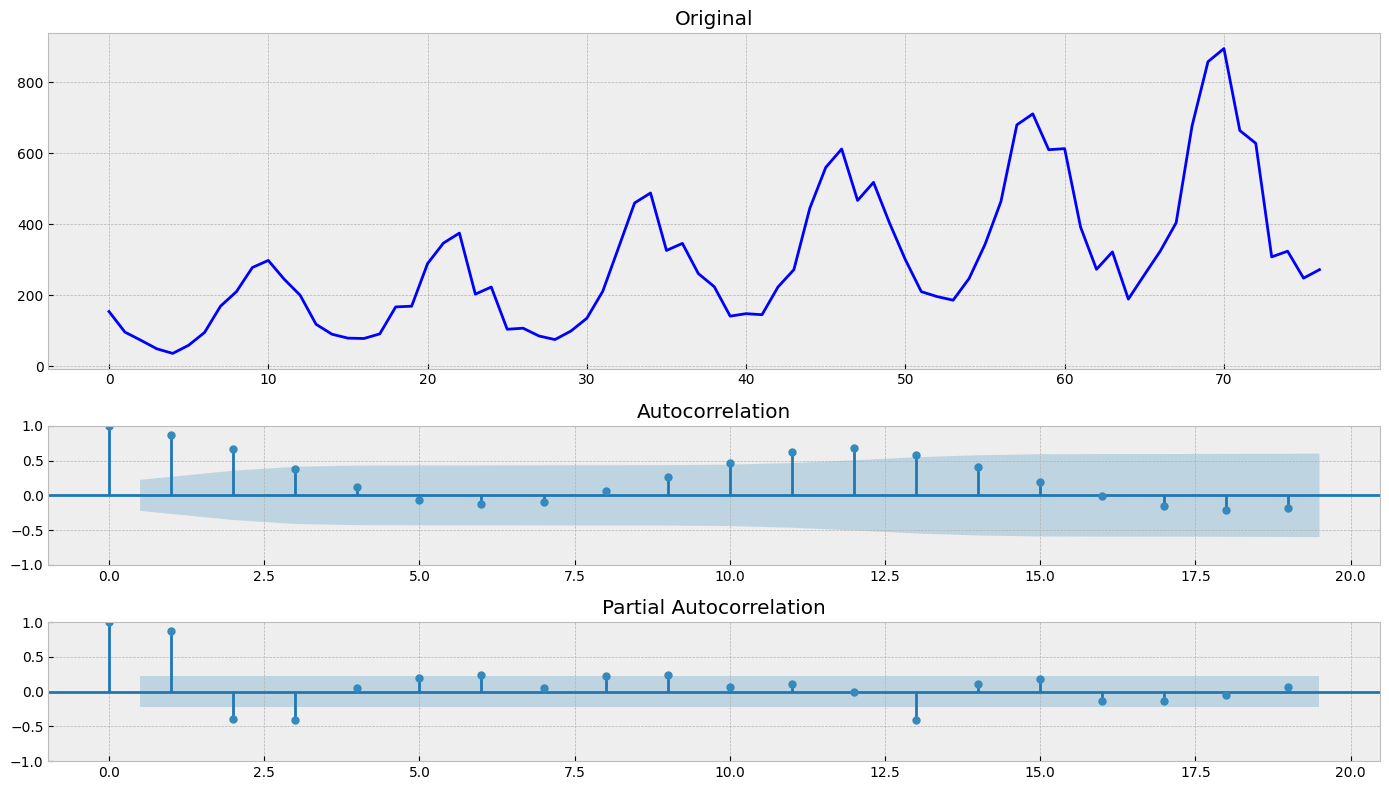

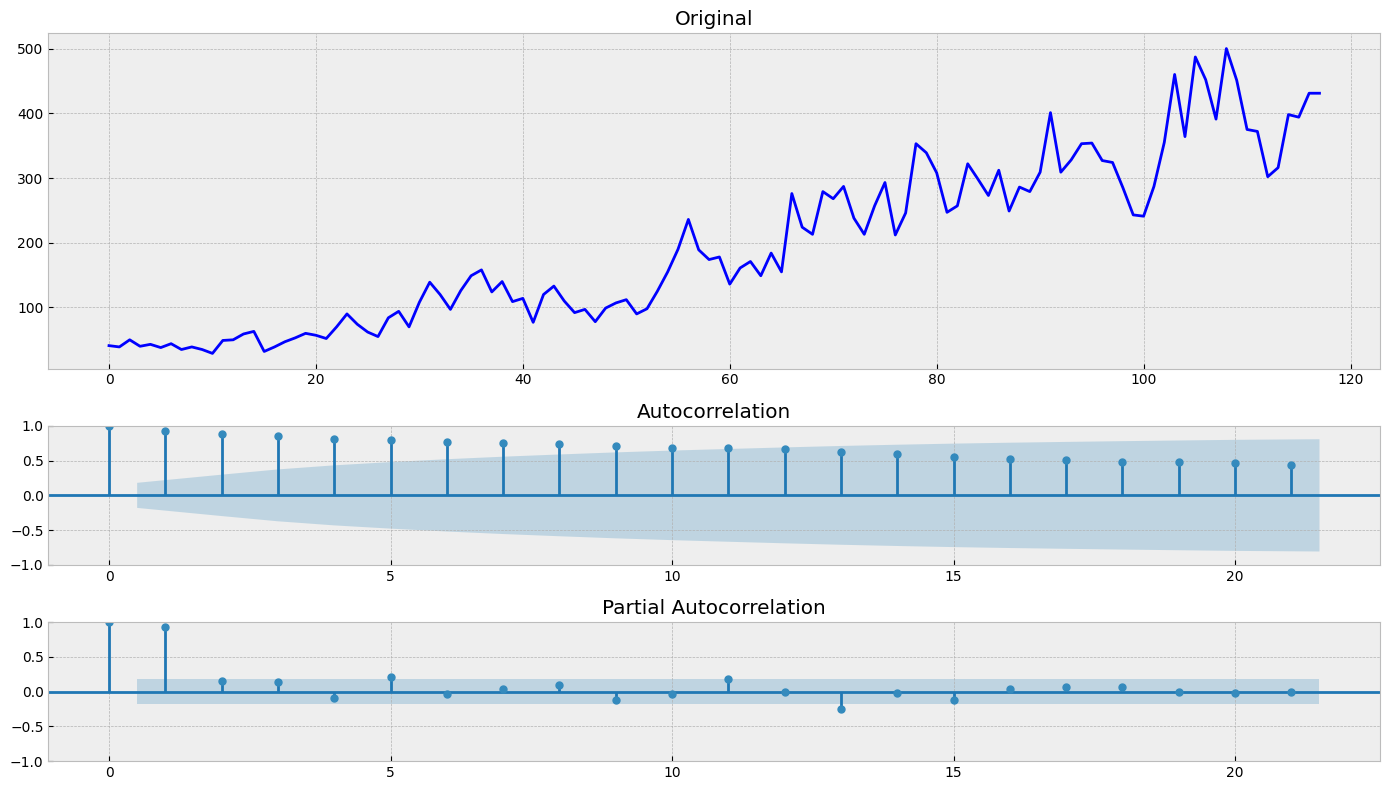

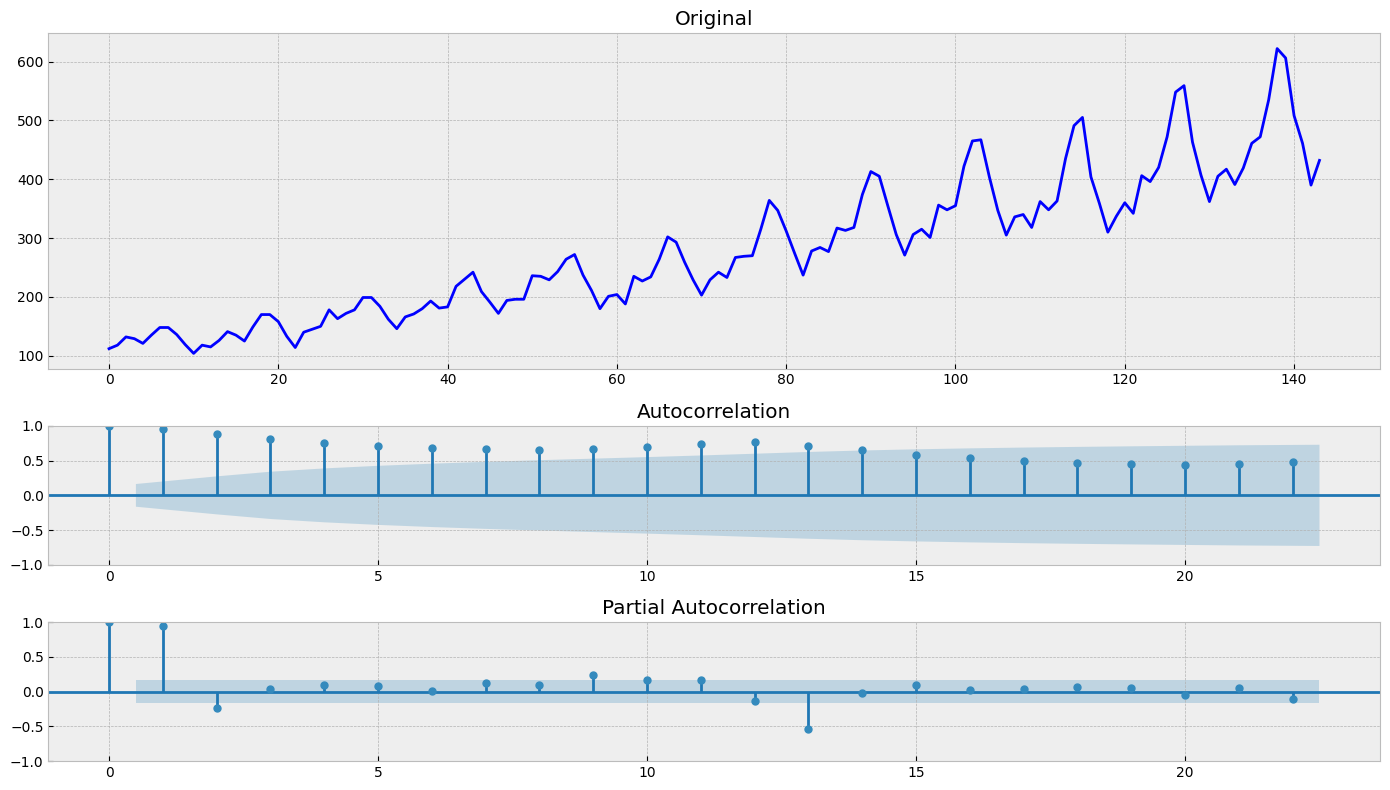

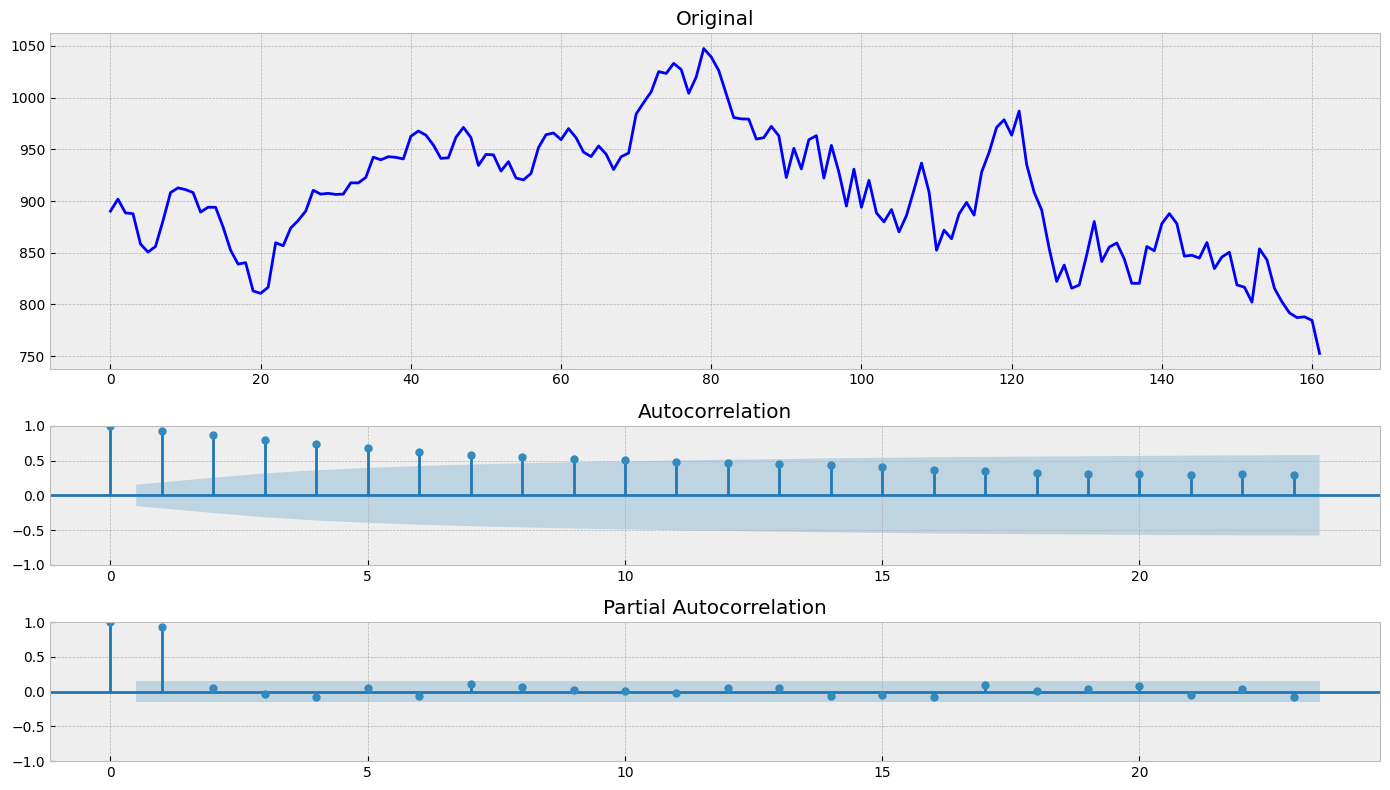

In [17]:
data_plots = {}
for key, value in all_series.items():
    test_results = test_stationarity(value)

    p_value = test_results.loc[test_results['parameters'] == 'p-value', 'value'].iloc[0]
    if p_value > .05:
        data_plots[key] = tsplot(value)

## **Box-Cox transformation**

In [96]:
box_cox_results = {}
for key, value in all_series.items():
    test_results = test_stationarity(value)

    p_value = test_results.loc[test_results['parameters'] == 'p-value', 'value'].iloc[0]
    if p_value > .05:
        box_cox_results[key] = [test_stationarity(boxcox(value)[0]), boxcox(value)[0]]

In [97]:
{key: value[0] for key, value in box_cox_results.items()}

{'Monthly sales of company X':                     parameters      value
 0               Test Statistic  -0.631279
 1                      p-value   0.863757
 2                    Lags Used  12.000000
 3  Number of Observations Used  64.000000
 4          Critical Value (1%)  -3.536928
 5          Critical Value (5%)  -2.907887
 6         Critical Value (10%)  -2.591493,
 'Monthly Boston armed robberies':                     parameters       value
 0               Test Statistic   -0.876346
 1                      p-value    0.795662
 2                    Lags Used   11.000000
 3  Number of Observations Used  106.000000
 4          Critical Value (1%)   -3.493602
 5          Critical Value (5%)   -2.889217
 6         Critical Value (10%)   -2.581533,
 'International airline passengers: monthly totals in thousands':                     parameters       value
 0               Test Statistic   -1.326071
 1                      p-value    0.617162
 2                    Lags Used   13.0000

## **Delete trend**

In [84]:
box_cox_all_series = {}
for key, value in box_cox_results.items():
    lags = value[0].loc[value[0]['parameters'] == 'Lags Used', 'value'].iloc[0]
    if lags != 0:
        box_cox_all_series[key] = value[1][int(lags):] - value[1][:-int(lags)]
    else:
        box_cox_all_series[key] = value[1][1:] - value[1][:-1]

In [88]:
box_cox_all_series_results = {}
for key, value in box_cox_all_series.items():
    test_results = test_stationarity(value)

    p_value = test_results.loc[test_results['parameters'] == 'p-value', 'value'].iloc[0]
    if p_value > .05:
       box_cox_all_series_results[key] = test_stationarity(value)

In [89]:
box_cox_all_series_results

{'Monthly sales of company X':                     parameters      value
 0               Test Statistic  -2.340504
 1                      p-value   0.159237
 2                    Lags Used  11.000000
 3  Number of Observations Used  53.000000
 4          Critical Value (1%)  -3.560242
 5          Critical Value (5%)  -2.917850
 6         Critical Value (10%)  -2.596796,
 'Monthly Boston armed robberies':                     parameters      value
 0               Test Statistic  -2.486715
 1                      p-value   0.118740
 2                    Lags Used  11.000000
 3  Number of Observations Used  95.000000
 4          Critical Value (1%)  -3.501137
 5          Critical Value (5%)  -2.892480
 6         Critical Value (10%)  -2.583275}

## **Delete trend 2.0**

In [90]:
final_box_cox_all_series = {}
for key, value in box_cox_all_series.items():
    test_results = test_stationarity(value)

    p_value = test_results.loc[test_results['parameters'] == 'p-value', 'value'].iloc[0]
    if p_value > .05:
        final_box_cox_all_series[key] = value[2:] - value[:-2]

In [92]:
final_box_cox_all_series_results = {}
for key, value in final_box_cox_all_series.items():
    final_box_cox_all_series_results[key] = test_stationarity(value)

In [93]:
final_box_cox_all_series_results

{'Monthly sales of company X':                     parameters         value
 0               Test Statistic -6.320973e+00
 1                      p-value  3.066843e-08
 2                    Lags Used  0.000000e+00
 3  Number of Observations Used  6.200000e+01
 4          Critical Value (1%) -3.540523e+00
 5          Critical Value (5%) -2.909427e+00
 6         Critical Value (10%) -2.592314e+00,
 'Monthly Boston armed robberies':                     parameters      value
 0               Test Statistic  -5.225916
 1                      p-value   0.000008
 2                    Lags Used   9.000000
 3  Number of Observations Used  95.000000
 4          Critical Value (1%)  -3.501137
 5          Critical Value (5%)  -2.892480
 6         Critical Value (10%)  -2.583275}

## **Final plots**

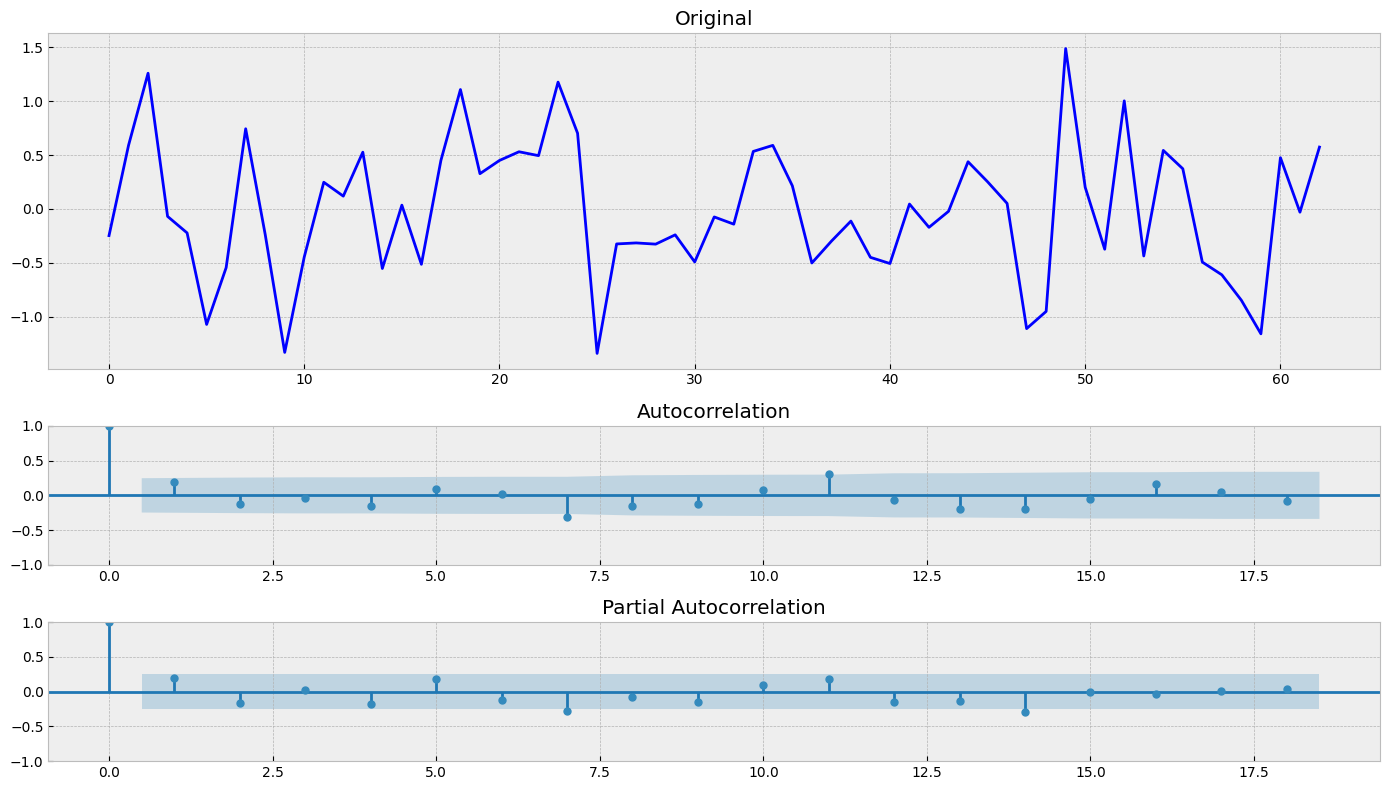

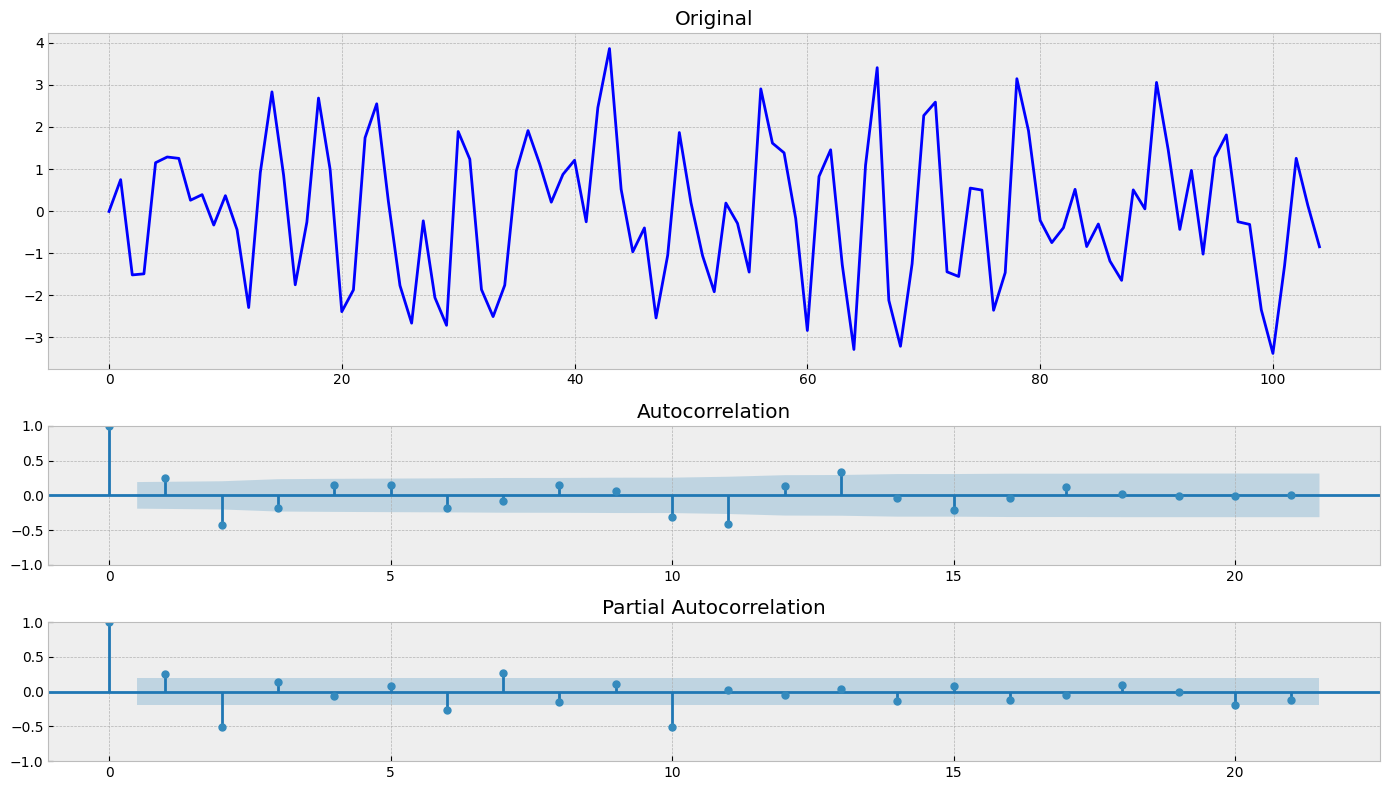

In [94]:
final_data_plots = {}
for key, value in final_box_cox_all_series.items():
    final_data_plots[key] = tsplot(value)